<a href="https://colab.research.google.com/github/AlexeyUdod/aml/blob/master/dll_9_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
%matplotlib inline

In [26]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
!wget https://www.manythings.org/anki/rus-eng.zip
!unzip rus-eng.zip

--2021-05-05 23:00:32--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.21.55.222, 2606:4700:3036::ac43:adc6, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14042100 (13M) [application/zip]
Saving to: ‘rus-eng.zip.1’

rus-eng.zip.1       100%[===================>]  13.39M  18.8MB/s    in 0.7s    

2021-05-05 23:00:33 (18.8 MB/s) - ‘rus-eng.zip.1’ saved [14042100/14042100]

Archive:  rus-eng.zip
replace rus.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [28]:
!tail rus.txt

Tom said, "You can kiss your girlfriend goodbye if you don't kiss her goodbye," which meant, "If you don't kiss your girlfriend goodbye, then you'll never see her again."	«Можешь попрощаться со своей подружкой, если ты с ней не попрощаешься», — сказал Том, что означало «если ты не попрощаешься со своей подружкой, то больше ты её никогда не увидишь».	CC-BY 2.0 (France) Attribution: tatoeba.org #1065032 (CK) & #4435211 (sharptoothed)
The more countries a language is spoken in, the less important it is to sound like a native speaker, since speakers of that language are accustomed to hearing various dialects.	Чем в большем количестве стран используется тот или иной язык, тем менее важно иметь такое же произношение, как у его носителей, так как носители этого языка привыкли к звучанию различных акцентов.	CC-BY 2.0 (France) Attribution: tatoeba.org #954354 (CK) & #4465953 (Wezel)
A mistake young people often make is to start learning too many languages at the same time, as they underestimate

In [29]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [30]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-Я.!?]+", r" ", s)
    return s

In [31]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines

    lines = open('rus.txt', encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:-1]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [32]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [33]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 421765 sentence pairs
Trimmed to 24895 sentence pairs
Counting words...
Counted words:
fra 9419
eng 4063
['я читаю газету .', 'i m reading the newspaper .']


The Encoder
-----------





In [34]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------




In [61]:
class AttnDecoderRNN_MLP(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN_MLP, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
      
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [62]:
class AttnDecoderRNN_scalar(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN_scalar, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax((embedded[0] @ encoder_outputs.T) / self.max_length**0.5, dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        output = self.attn_combine(torch.cat((embedded[0], attn_applied[0]), 1)).unsqueeze(0)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [36]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [37]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [38]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [39]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [40]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [41]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [42]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 8s (- 16m 4s) (5000 6%) 3.0482
2m 15s (- 14m 39s) (10000 13%) 2.5819
3m 21s (- 13m 25s) (15000 20%) 2.2917
4m 27s (- 12m 15s) (20000 26%) 2.1196
5m 33s (- 11m 7s) (25000 33%) 1.9513
6m 40s (- 10m 0s) (30000 40%) 1.8199
7m 47s (- 8m 54s) (35000 46%) 1.7332
8m 53s (- 7m 46s) (40000 53%) 1.6450
10m 0s (- 6m 40s) (45000 60%) 1.5537
11m 6s (- 5m 33s) (50000 66%) 1.4997
12m 13s (- 4m 26s) (55000 73%) 1.4292
13m 20s (- 3m 20s) (60000 80%) 1.3364
14m 26s (- 2m 13s) (65000 86%) 1.3185
15m 33s (- 1m 6s) (70000 93%) 1.2719
16m 40s (- 0m 0s) (75000 100%) 1.2226


<Figure size 432x288 with 0 Axes>

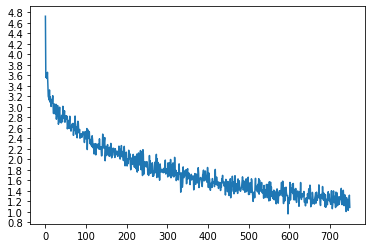

In [63]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN_MLP(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 8s (- 16m 1s) (5000 6%) 3.0594
2m 15s (- 14m 38s) (10000 13%) 2.5699
3m 22s (- 13m 29s) (15000 20%) 2.3203
4m 29s (- 12m 22s) (20000 26%) 2.1361
5m 37s (- 11m 15s) (25000 33%) 1.9323
6m 44s (- 10m 7s) (30000 40%) 1.8098
7m 52s (- 9m 0s) (35000 46%) 1.6883
9m 0s (- 7m 52s) (40000 53%) 1.6282
10m 8s (- 6m 45s) (45000 60%) 1.5160
11m 16s (- 5m 38s) (50000 66%) 1.4539
12m 25s (- 4m 30s) (55000 73%) 1.3969
13m 33s (- 3m 23s) (60000 80%) 1.3139
14m 40s (- 2m 15s) (65000 86%) 1.2407
15m 48s (- 1m 7s) (70000 93%) 1.1847
16m 56s (- 0m 0s) (75000 100%) 1.1465


<Figure size 432x288 with 0 Axes>

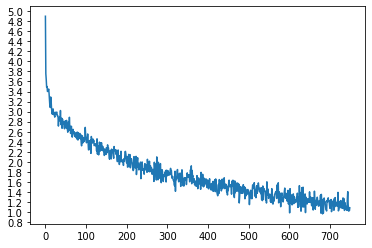

In [64]:
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN_scalar(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder2, attn_decoder2, 75000, print_every=5000)

In [65]:
evaluateRandomly(encoder1, attn_decoder1)

> рад за вас .
= i m happy for you .
< i m happy for you . <EOS>

> он не едет .
= he s not going .
< he s not going . <EOS>

> ты оптимист .
= you re optimistic .
< you re an optimist . <EOS>

> мы в однои лодке .
= we re in the same boat .
< we re in the same boat . <EOS>

> я уже не сержусь на тома .
= i m not mad at tom anymore .
< i m not angry at tom . <EOS>

> я напряжен .
= i m tense .
< i m lazy . <EOS>

> вы мне не мать .
= you aren t my mother .
< you re not my mother . <EOS>

> сегодня вечером я свободна .
= i m free this evening .
< i m free tonight . <EOS>

> ты трус !
= you re a coward !
< you re a ! <EOS>

> он безнадежно влюблен .
= he s hopelessly in love .
< he s sure in love . <EOS>



In [66]:
evaluateRandomly(encoder2, attn_decoder2)

> я уже не сержусь .
= i m not angry anymore .
< i m not angry anymore . <EOS>

> мы в хорошеи форме .
= we re in good shape .
< we re in good shape . <EOS>

> я главныи администратор .
= i m the ceo .
< i m a . . <EOS>

> ты очень сильныи .
= you re very strong .
< you re very strong . <EOS>

> уверен ты ошибаешься .
= i m sure you re wrong .
< you m sure you are wrong . <EOS>

> вы у меня в гостях .
= you re my guests .
< you re my my . <EOS>

> я говорю о своем друге .
= i m talking about my friend .
< i m talking about my friends . <EOS>

> мне не удается скомпилировать эту программу .
= i m having some problems compiling this software .
< i m not interested in this this . <EOS>

> она отправилась в путешествие .
= she s gone on a trip .
< she s on in a . <EOS>

> он вдвое старше меня .
= he is twice as old as i am .
< he is twice as old as i am . <EOS>



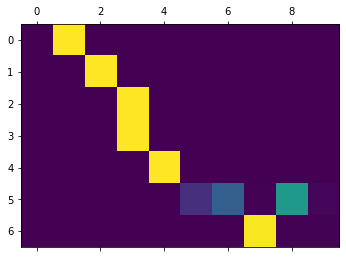

In [67]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "он боится смерти .")
plt.matshow(attentions.numpy())
plt.show()

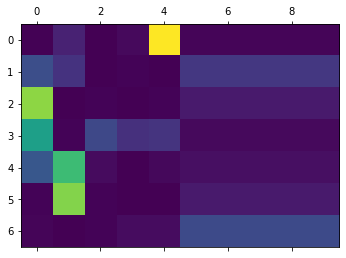

In [68]:
output_words, attentions = evaluate(
    encoder2, attn_decoder2, "он боится смерти .")
plt.matshow(attentions.numpy())
plt.show()

input = я на тебя рассчитываю .
output = i m counting on you . <EOS>


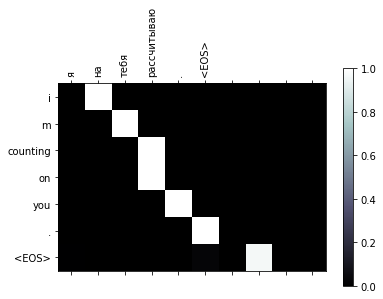

input = я везу тома в больницу .
output = i m going to tom s in . <EOS>


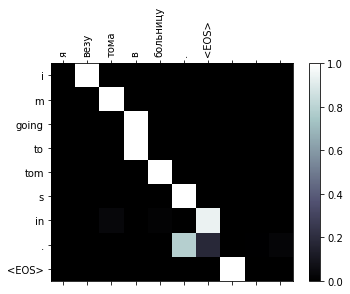

In [69]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("я на тебя рассчитываю .")

evaluateAndShowAttention("я везу тома в больницу .")


input = я на тебя рассчитываю .
output = i m counting on you . <EOS>


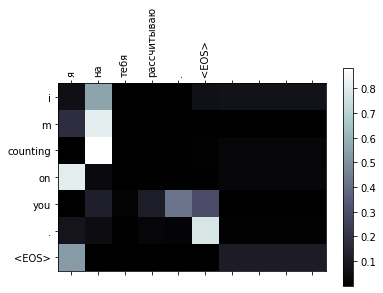

input = я везу тома в больницу .
output = i m going to tom tom . <EOS>


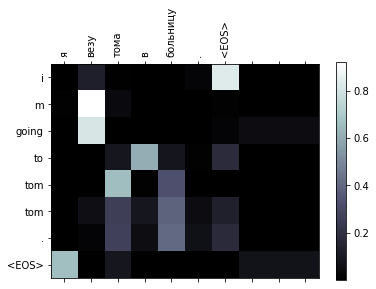

In [70]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder2, attn_decoder2, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("я на тебя рассчитываю .")

evaluateAndShowAttention("я везу тома в больницу .")
